In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")
from keras.wrappers.scikit_learn import KerasClassifier

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [18]:
df = pd.read_csv('../data/twitter_training.csv')
df = pd.DataFrame(df.values, columns = ['id', 'game', 'target', 'text'])
df = df.dropna()
df

,id,game,target,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [19]:
(set(df['game'].values))
print(f'Game column has {len(set(df["game"].values))} unique categories')
print('Targets have these values:\n', set(df["target"].values))

Game column has 32 unique categories
Targets have these values:
 {'Negative', 'Positive', 'Neutral', 'Irrelevant'}


In [20]:
df.groupby('target').count()

,id,game,text
target,,,
Irrelevant,12875,12875,12875
Negative,22358,22358,22358
Neutral,18108,18108,18108
Positive,20654,20654,20654


Targets are slightly unbalanced

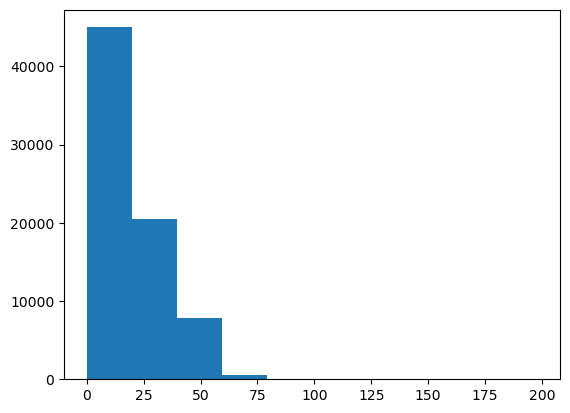

In [30]:
lens = []
for i in df['text'].values:
    lens.append(len(i.split()))
    
plt.hist(lens)
plt.show()

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


In [25]:
df = df.drop('id', axis = 1)
lbl = LabelEncoder()
df['game'] = lbl.fit_transform(df['game'])

In [36]:
mapa = {'Positive':3,
        'Neutral': 2,
        'Negative': 1,
        'Irrelevant': 2}
rev = {}
for i in mapa.keys():
    rev[mapa.get(i)] = i

df['target'] = df['target'].apply(lambda x: mapa[x])
y = df['target']
x = df.drop('target', axis=1)
x

KeyError: 3

In [37]:
y = df['target']
x = df.drop('target', axis=1)
x

,game,text
0,4,I am coming to the borders and I will kill you...
1,4,im getting on borderlands and i will kill you ...
2,4,im coming on borderlands and i will murder you...
3,4,im getting on borderlands 2 and i will murder ...
4,4,im getting into borderlands and i can murder y...
...,...,...
74676,21,Just realized that the Windows partition of my...
74677,21,Just realized that my Mac window partition is ...
74678,21,Just realized the windows partition of my Mac ...
74679,21,Just realized between the windows partition of...


In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [85]:
vocab_size = 500
embedding_dim = 16
max_length = 50
num_classes = len(np.unique(y_train))
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['text'])
word_index = tokenizer.word_index

In [72]:
y_train = tf.keras.utils.to_categorical(y_train.values, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test.values, num_classes=num_classes)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [86]:
sequences = tokenizer.texts_to_sequences(X_train['text'])
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test['text'])
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [87]:
padded.shape

(59196, 50)

## Modelling

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [105]:
model.compile(loss="categorical_crossentropy", optimizer= "adam",
              metrics=['accuracy'])

In [106]:
num_epochs = 50
history = model.fit(padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test))

Epoch 1/50
1850/1850 [==============================] - 3s 2ms/step - loss: 1.2663 - accuracy: 0.4094 - val_loss: 1.2035 - val_accuracy: 0.4893
Epoch 2/50
1850/1850 [==============================] - 3s 1ms/step - loss: 1.1077 - accuracy: 0.5338 - val_loss: 1.0775 - val_accuracy: 0.5520
Epoch 3/50
1850/1850 [==============================] - 3s 2ms/step - loss: 1.0483 - accuracy: 0.5611 - val_loss: 1.0516 - val_accuracy: 0.5518
Epoch 4/50
1850/1850 [==============================] - 3s 1ms/step - loss: 1.0250 - accuracy: 0.5679 - val_loss: 1.0388 - val_accuracy: 0.5577
Epoch 5/50
1850/1850 [==============================] - 3s 1ms/step - loss: 1.0136 - accuracy: 0.5740 - val_loss: 1.0281 - val_accuracy: 0.5654
Epoch 6/50
1850/1850 [==============================] - 3s 1ms/step - loss: 1.0055 - accuracy: 0.5733 - val_loss: 1.0181 - val_accuracy: 0.5694
Epoch 7/50
1850/1850 [==============================] - 3s 2ms/step - loss: 0.9986 - accuracy: 0.5775 - val_loss: 1.0152 - val_accuracy:

In [107]:
model.evaluate(testing_padded, y_test)

463/463 [==============================] - 1s 1ms/step - loss: 0.9250 - accuracy: 0.6219


[0.9249573349952698, 0.6218663454055786]